# Data

Parse JSON

In [51]:
# add the parent directory to Python path
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

# load test json in jupyter notebook
import json
with open("../big_dataset.json") as f:
    dic = json.load(f)
    dic = dic["data"] # when run Launcher.ipynb, comment this out

import numpy as np
def get_subdic(dic, size=13):
    keys = list(dic.keys())
    selected_keys = np.random.choice(keys, size=size, replace=False)
    return {key: dic[key] for key in selected_keys}

# Parse data into assets and
from utils import json_parse
price_df, esg_s, asset_arr = json_parse(get_subdic(dic, size=7))

Preprocess μ and Σ

In [52]:
# Calculates mu and sigma using OAS, LedoitWolf or normal cov
from utils import compute_mu_sigma
mu, Sigma = compute_mu_sigma(price_df, lookback=252, shrinkage=True)

Helper function

In [19]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

    return selection

# Imports

In [17]:
# # Find all corrupted package directories
# !find /opt/conda/lib/python3.12/site-packages/ -name "*~*" -type d

# # Remove ALL corrupted package directories
# !find /opt/conda/lib/python3.12/site-packages/ -name "*~*" -type d -exec rm -rf {} +

In [18]:
# !pip uninstall qiskit qiskit-finance qiskit-aer qiskit-algorithms qiskit-optimization -y

In [19]:
# !pip install qiskit==1.4.2
# !pip install qiskit-finance==0.4.1
# !pip install qiskit-aer==0.13.3
# !pip install qiskit-algorithms==0.3.0
# !pip install qiskit-optimization==0.6.1

# !pip install qiskit-aer
# !pip install qiskit
# !pip install qiskit-algorithms
# !pip install qiskit-optimization
# !pip install qiskit-finance

In [6]:
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA
from qiskit_algorithms.optimizers import COBYLA
from myport import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime

# QAOA solver

Using QAOA solver we are constarained to have our weightage $w\in\{0,1\}$.

$$
\min_{x\in\{0,1\}^n} qx^T\sum x - \mu^Tx
$$
This is subject to budget constaint:
$$
1^Tx=B\quad\text{(number of assests to be selected out of $n$)}
$$
The penalty term is therefore:
$$
P=\left(1^Tx-B\right)^2
$$

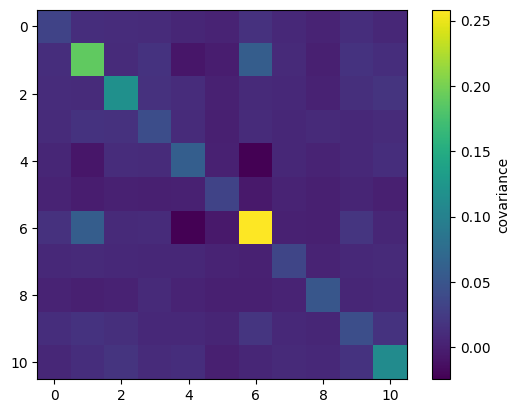

In [40]:
plt.imshow(Sigma, interpolation="nearest")
plt.colorbar(label="covariance")
plt.show()

In [53]:
# Create optimization equation
num_assets = len(mu)
q = 1  # set risk factor
budget = num_assets // 2  # set budget
penalty = min(num_assets, 1000)  # Cap the penalty (this is good assumption generally_

portfolio = PortfolioOptimization(expected_returns=mu, covariances=Sigma, risk_factor=q, budget=budget, esg_scores=esg_s, roi_factor=1, esg_factor=0.01)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.10913399172610576*x_0^2 + 0.005610210040962318*x..., 7 variables, 1 constraints, 'Portfolio optimization'>

# Classical Eigensolver

In [10]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.], value -3.4478

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 1 0 0 0 1 0 1 0 1 0 1 0]	-3.4478		1.0000


array([0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.])

In [48]:
%%timeit
exact_eigensolver.solve(qp)

40.3 ms ± 204 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Using QAOA

In [54]:
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime

from utils import PortfolioOptimization, print_result
from quantinuum_wrapper import QuantinuumWrapper

# ----------------------------------------------------------
# STEP 1: Connect to backend
# ----------------------------------------------------------
backend = QuantinuumWrapper.get_target()

# ----------------------------------------------------------
# STEP 2: Classical pre-screening (reduce 50 -> ≤33 assets)
# ----------------------------------------------------------
def select_top_assets(mu, esg_s, top_k=33, method="return_esg"):
    """
    Simple classical feature reduction.
    - mu: expected returns
    - esg_s: ESG scores
    - method: scoring heuristic
    - top_k: number of assets to keep
    Returns the indices of the selected assets.
    """
    mu = np.array(mu)
    esg_s = np.array(esg_s)

    if method == "return_esg":
        # Example score: favor higher returns, moderate ESG
        scores = mu - 0.01 * esg_s
    elif method == "return_only":
        scores = mu
    elif method == "random":
        scores = np.random.random(len(mu))
    else:
        raise ValueError("Unknown selection method")

    # Pick top_k assets by score
    top_indices = np.argsort(scores)[-top_k:]
    return np.sort(top_indices)

# ----------------------------------------------------------
# Original data (assumed defined elsewhere)
# ----------------------------------------------------------
# mu: expected returns vector (length 50)
# Sigma: covariance matrix (50x50)
# esg_s: ESG scores vector (length 50)
# q: risk factor

num_assets_total = len(mu)
available_qubits = 15

# Select assets to fit hardware limit
selected_idx = select_top_assets(mu, esg_s, top_k=available_qubits)
print(f"Selected assets: {selected_idx.tolist()}")

# Reduce problem data
mu_red = np.array(mu)[selected_idx]
Sigma_red = np.array(Sigma)[np.ix_(selected_idx, selected_idx)]
esg_s_red = np.array(esg_s)[selected_idx]

# ----------------------------------------------------------
# STEP 3: Build reduced optimization problem
# ----------------------------------------------------------
q = 1  # risk factor
budget = len(mu_red) // 2
penalty = min(len(mu_red), 1000)

portfolio = PortfolioOptimization(
    expected_returns=mu_red,
    covariances=Sigma_red,
    risk_factor=q,
    budget=budget,
    esg_scores=esg_s_red,
    roi_factor=1,
    esg_factor=0.01
)
qp = portfolio.to_quadratic_program()

# ----------------------------------------------------------
# STEP 4: Define QAOA solver
# ----------------------------------------------------------
cobyla = COBYLA()
cobyla.set_options(maxiter=250)

sampler = Sampler()
sampler.set_options(backend=backend)

qaoa_mes = QAOA(sampler=sampler, optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)

# ----------------------------------------------------------
# STEP 5: Solve reduced problem
# ----------------------------------------------------------
result = qaoa.solve(qp)
q = print_result(result, portfolio, print_comb=False)

# ----------------------------------------------------------
# STEP 6 (optional): Reconstruct full 50-asset vector
# ----------------------------------------------------------
full_selection = np.zeros(num_assets_total)
full_selection[selected_idx] = result.x  # insert results back into full vector

print("Full 50-asset portfolio (zero-padded):")
print(full_selection)


Selected assets: [0, 1, 2, 3, 4, 5, 6]
Optimal: selection [1. 0. 0. 0. 1. 1. 0.], value -1.5973
Full 50-asset portfolio (zero-padded):
[1. 0. 0. 0. 1. 1. 0.]


In [55]:
%%timeit
result = qaoa.solve(qp)
q = print_result(result, portfolio, print_comb=False)

Optimal: selection [0. 0. 0. 1. 1. 1. 0.], value -1.3478
Optimal: selection [1. 0. 0. 0. 1. 1. 0.], value -1.5973
Optimal: selection [1. 0. 0. 0. 1. 1. 0.], value -1.5973
Optimal: selection [1. 0. 0. 1. 0. 1. 0.], value -1.5916
Optimal: selection [1. 0. 0. 0. 1. 1. 0.], value -1.5973
Optimal: selection [1. 0. 0. 1. 0. 1. 0.], value -1.5916
Optimal: selection [1. 0. 0. 0. 1. 1. 0.], value -1.5973
Optimal: selection [1. 0. 0. 0. 1. 1. 0.], value -1.5973
1.44 s ± 67.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


risk or credit score metric

In [14]:
print(q)

[0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0.]


In [44]:
new = np.multiply(q,mu) / np.dot(np.multiply(q,mu),q)

In [49]:
sum(new)

0.9999999999999998